In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from pylab import rcParams
from scipy.stats import norm

import grmpy

rcParams["figure.figsize"] = 15, 10
rcParams["font.size"] = 18

%matplotlib inline

display(HTML("<style>.container { width:80% !important; }</style>"))


# The *grmpy*  package 
This notebook demonstrates the current capabilities of the *grmpy* package. *grmpy* is an open source package for the programming language python that enables researchers to simulate datasets andestimate parameters using already existing data within the structure of the generalized Roy model. Currently the package serves as a teaching tool for a course on the econometrics of policy evaluation at the University of Bonn. The corresponding lecture materials can be found on [GitHub](https://github.com/HumanCapitalAnalysis/econometrics).  Morover it is thought of as a promotion for the conceptual framework as well as a showcase for basic software engineering practices.

For a more detailed overview on the economic background as well as the installation routine feel free to take a look on the [online documentation](https://grmpy.readthedocs.io/en/develop/).

The notebook itself is divided in three parts. Firstly we provide a basic outline on how to use the package and introduce the core features. Next we will show that the results obtained by the package's estimation process withstand a critical examination by comparing its performance in the presence of essential heterogeneity with several other estimation approaches like Ordinary Least Squares and Instrumental variables. We conclude by conducting a replication of results from   

Carneiro, P., Heckman, J. J., & Vytlacil, E. J. (2011). [Estimating marginal returns to education.](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754)
*American Economic Review, 101*(6), 2754-81.


## Notes

We build on the following main references:

* James J. Heckman and Edward J. Vytlacil. Econometric evaluation of social programs, part I: Causal models, structural models and econometric policy evaluation. In *Handbook of Econometrics*, volume 6B, chapter 70, pages 4779–4874. Elsevier Science, 2007.

* James J. Heckman and Edward J. Vytlacil. Econometric evaluation of social programs, part II: Using the marginal treatment effect to organize alternative econometric estimators to evaluate social programs, and to forecast their effects in new environments. In *Handbook of Econometrics*, volume 6B, chapter 71, pages 4875–5143. Elsevier Science, 2007.

* Jaap H. Abbring and James J. Heckman. Econometric evaluation of social programs, part III: Distributional treatment effects, dynamic treatment effects, dynamic discrete choice, and general equilibrium policy evaluation. In *Handbook of Econometrics*, volume 6B, chapter 72, pages 5145–5303. Elsevier Science, 2007.

## General Framwork

$$
\begin{align*}
 &\textbf{Potential Outcomes} & & \textbf{Choice}  &\\
 & Y_{1,i} = \mu_1(X_i) + U_{1,i} &  &C_i = \mu_C(Z_i) - V &\\
 & Y_{0,i} = \mu_0(X_i) + U_{0,i} &  & D_i = \left\{
\begin{array}{ll}
1 & if \ C_i > 0 \\
0 &  \text{otherwise}\\
\end{array}
\right.  &\\
&&&&\\
&\textbf{Distributional Characteristics}&&&\\
&\{U_{1}, U_{0}, V\} \sim \left(0, \Sigma\right)&&&\\
&&&&\\
& \textbf{Observed Outcome} &&&\\
& Y_i = D_i Y_{1,i} + (1-D_i) Y_{0,i} &&&
\end{align*}
$$


#### Choice Process
- $Z_i$ captures all observable factors that affect the decision of an individual to select itself into treatment


- $V_i$ denotes (from perspective of the econometrician) unobservable components that drive the selection decision (Note: V enters with a negative sign $\Rightarrow$ conditional on $Z_i$, high values of $V_i$ indicate a lower propensity to select into treatment


- $C_i$ is the latent propensity indicator of individual $i$ 


- $D_i$ indicates whether an individual selects itself in the treatment group


- Furthermore we can rearrange $D_i$ s.t. the individual selects into treatment if

$$
\begin{align*}
&\;\mu_C(Z_i) > V_i\\
\Leftrightarrow&\;F_V(\mu_C(Z_i)) > F_V(V_i)\\
&\\
 \Rightarrow& \; D_i = \mathbb{1}\{F_V(\mu_C(Z_i)) > F_V(V_i)\}
\end{align*}
$$

- $F_V(\mu_C(Z_i))$: Probability of being treated given an individual's observable characteristics (propensity score)


- $F_V(V_i)$: The quantile of $V$'s distribution the individual's realization $V_i$ is located in

**$\Rightarrow$ The individuals select themselves into treatment when their propensity score outruns the quantile of the distribution $V_i$**





#### Outcomes
- $(Y_{1,i}, Y_{0,i})$ denotes the set of potential outcomes of individual $i$


- $Y_i$ denotes the observable outcome of individual $i$


- Rearranging the outcome equation leads to:


$$
\begin{align*}
Y_i = Y_{0,i} + D_i \underbrace{(Y_{1,i} - Y_{0,i})}_{\Delta_i}
\end{align*}
$$

- $\Delta_i$ : Causal effect of treatment for individual $i$

**Evaluation Problem**

The set of equations above entails one of the most crucial challenges for the evaluation of policy interventions. We as researchers are not able to observe the potential outcome space for an individual but instead we observe either $Y_{1,i}$ or $Y_{0,i}$ for one and the same individual dependent on the individual's selection decision. This is referred to as the **evaluation problem**.

## Heterogeneity
Central question in all econometrics of policy analysis:

_What gives rise to variation and outcomes among, from the econometrician’s perspective, otherwise identical agents?_ (Heckman 2001)

**Answer: Heterogeneity**

$$
\begin{align*}
\Delta_i = Y_{1,i} - Y_{0,i} = \underbrace{\mu_1(X_i) - \mu_0(X_i)}_{\text{average effect}} + \underbrace{U_{1,i} -U_{0,i}}_{\text{individual specific effect}}
\end{align*}
$$

- **Observable heterogeneity:** 

    * Is reflected by the first term of the equation.
    
    * Denotes the differences between individuals, which are based on differences in observable characteristics captured by $X_i$
    
    * Note that since we observe $X_i$, we are able to ćondition on it
    
    
- **Unobservable heterogeneity:**
    * Represented by the difference in the unobservables.
    * Note: The term *unobservable* does not imply that $U_{1,i}$ and $U_{0,i}$ are completely excluded in an individual's information set. 

**Question: When does unobservable heterogeneity pose problems in the analysis of average effect parameters?**


**Answer: If the individual's selection process depends on unobservable "gains" we have a selection problem.**


This kind of heterogeneity is referred to as **essential heterogeneity** 
* The reaction on interventions are heterogeneous among individuals

* Individuals select their treatment state with at least partly knowledge of their own responses to treatment.


## Parameters of Interest

- In a perfect world we as economists would focus on determining $\Delta_i$. In reality this is impossible due to the aformentioned evaluation problem!


- For this reason, the analysis of conventional treatment effect analysis is confined to the identification of average effects for specific subgroups. 

- The common subgroups are the whole population ($\Delta^{ATE}$), the treated ($\Delta^{TT}$) or the untreated share ($\Delta^{TUT}$). The effects are characterized by the following equations

$$
\begin{align*}
 \Delta^{ATE} &= E[Y_1 -Y_0] \\
 \Delta^{TT}\;\; &= E[Y_1 -Y_0|D=1]\\
 \Delta^{TUT} &= E[Y_1 -Y_0|D=0]
\end{align*}
$$

- When treatment is randomly assigned or the selection is not based on the potential outcomes there is no significant difference between the average individuals with different treatment states.


- Therefore all effects are identical! And we can substitute $E[Y_1]$ and $E[Y_0]$ with the observed average outcomes $E[Y|D=1]$ and $E[Y|D=0]$.


$$
\begin{align*}
 \Delta^{ATE} =  \Delta^{TUT} =  \Delta^{TT} = E[Y|D=1] - E[Y|D=0]
\end{align*}
$$

## Illustration

For reasons of simplicity I will make use of the normal-linear-in-parameters version generalized Roy model. In addition we assume that the unobservable terms $\{U_1, U_0, V\}$ are normally distributed according to the covariance matrix $\Sigma$. The following set of equations characterize the underlying model:

$$
\begin{align*}
 &\textbf{Potential Outcomes} & & \textbf{Choice}  &\\
 & Y_1 = \beta_1 X + U_{1} &  &D_i = \mathbf{1}\{\Phi(\gamma Z) > u_D\} &\\
 & Y_0 = \beta_0 X + U_{0} &  & \text{with $u_D = \Phi(V)$}  &\\
&&&&\\
&\textbf{Distributional Characteristics}&&&\\
&\{U_{1}, U_{0}, V\} \sim \mathcal{N}\left(0, \Sigma\right)&&\Sigma =  \begin{bmatrix}
    \sigma_1^{2} & \sigma_{1,0} & \sigma_{1,V} \\
    \sigma_{1,0} & \sigma_0^{2} & \sigma_{0,V} \\
    \sigma_{1,V} & \sigma_{0,V} & \sigma_V^{2} \\
  \end{bmatrix}&\\
&&&&\\
& \textbf{Observed Outcome} &&&\\
& Y = D Y_1 + (1-D) Y_0 &&&
\end{align*}
$$


In [2]:
# Configuration file for simulation without essential heterogeneity
# Located at: files/no_eh.grmpy.yml

In [3]:
config_no_eh = grmpy.process_config("files/no_eh.grmpy.yml")
sim_result = grmpy.simulate(config_no_eh)
df = sim_result.data

In [4]:
df.head(10)

,X0,X1,Z0,Z1,Z2,U1,U0,V,Y1,Y0,D,Y
0,1.0,-0.014710,0.023439,0.282623,1.941447,0.008463,0.194329,0.767310,0.493753,0.179619,1.0,0.493753
1,1.0,0.183810,-0.220668,1.555453,0.955393,0.275395,0.210137,-0.567979,0.959205,0.393947,1.0,0.959205
2,1.0,0.192161,0.153950,-0.295161,1.663835,0.248421,0.025742,-0.307828,0.940582,0.217903,1.0,0.940582
3,1.0,2.030613,0.845409,-0.942922,-0.189934,-0.017626,0.174089,-1.129202,2.512987,2.204702,1.0,2.512987
4,1.0,-1.366937,0.590819,1.731056,0.962988,-0.352700,0.245884,-0.024787,-1.219637,-1.121053,1.0,-1.219637
5,1.0,1.133287,-2.132983,-1.378429,0.020067,-0.306381,-0.272525,0.117710,1.326907,0.860762,0.0,0.860762
6,1.0,-0.089817,-0.279000,-0.303465,0.212042,0.061352,-0.143145,-0.037156,0.471536,-0.232961,0.0,-0.232961
7,1.0,0.424800,0.140421,-0.949804,3.360257,-0.275345,0.103145,0.719759,0.649456,0.527945,1.0,0.649456
8,1.0,0.997728,-0.053163,-0.008147,0.812770,0.157917,-0.635378,0.749826,1.655646,0.362350,0.0,0.362350
9,1.0,0.962076,-1.210027,0.850223,-2.212943,0.479441,0.050065,-1.119519,1.941517,1.012141,1.0,1.941517


In [5]:
indicator = df.D == 1
Delta = df["Y1"] - df["Y0"]
ATE = np.mean(df["Y1"] - df["Y0"])
TT = np.mean(df[indicator]["Y1"] - df[indicator]["Y0"])
TUT = np.mean(df[~indicator]["Y1"] - df[~indicator]["Y0"])

effect_est = np.mean(df[indicator]["Y"]) - np.mean(df[~indicator]["Y"])

/tmp/ipykernel_89085/2708484325.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Delta, kde=True, hist=False)


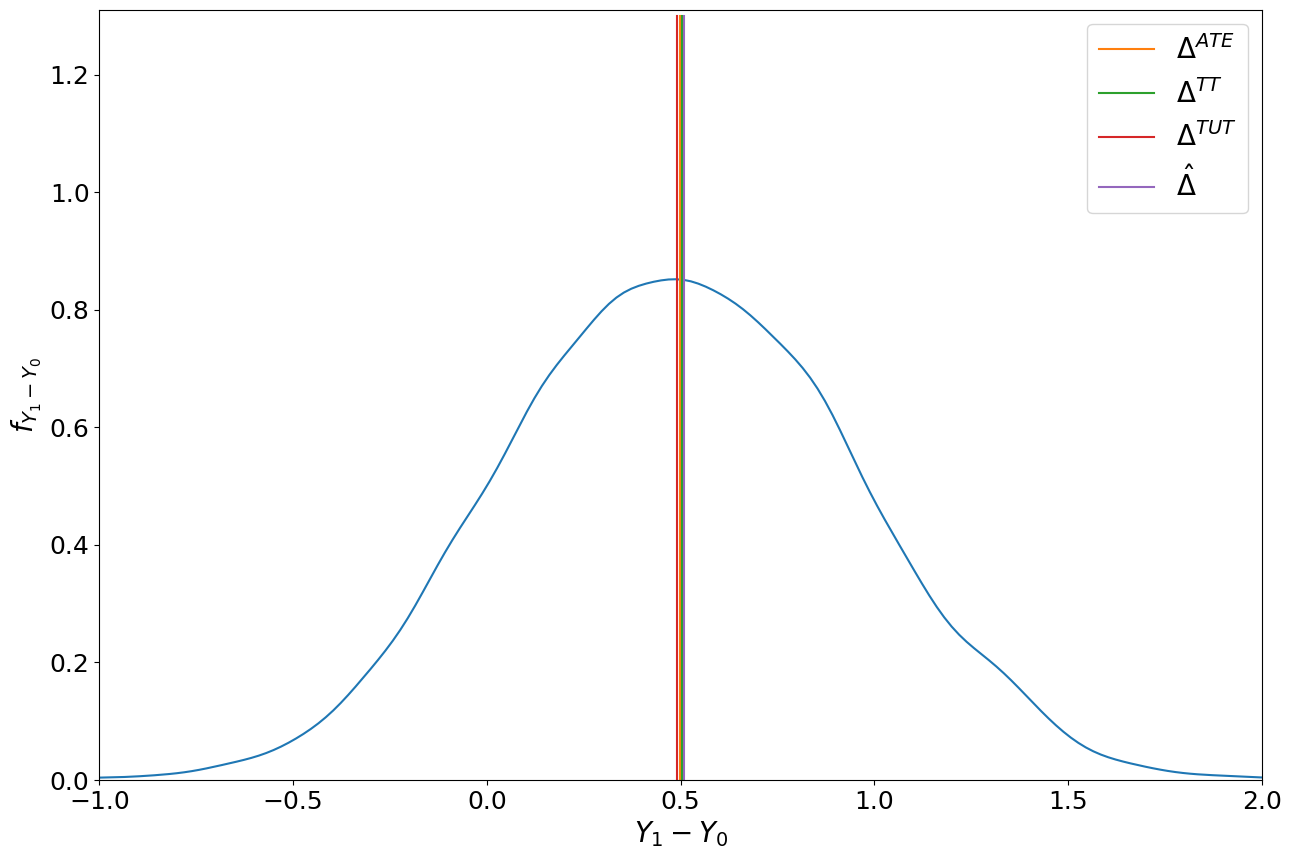

In [6]:
# set up figure object
ax = plt.figure(figsize=(15, 10))
plt.ylabel("$f_{Y_1 - Y_0}$", fontsize=20)
plt.xlabel("$Y_1 - Y_0$", fontsize=20)
plt.axis([-1, 2, 0.0, 1.31])

# plot distribution of individual effects
sns.distplot(Delta, kde=True, hist=False)

# plot average effect parameters
plt.plot([ATE, ATE], [0.00, 1.3], label=r"$\Delta^{ATE}$")
plt.plot([TT, TT], [0.00, 1.3], label=r"$\Delta^{TT}$")
plt.plot([TUT, TUT], [0.00, 1.3], label=r"$\Delta^{TUT}$")
plt.plot([effect_est, effect_est], [0.00, 1.3], label=r"$\hat{\Delta}$")


plt.legend(prop={"size": 20})

- The figure should not lead to the false assumptions that all introduced parameters measure the same effect.

- If individuals select themselves into treatment based on outcome related characteristics (the potential outcomes $Y_1, Y_0$ are no longer independent of the treatment status $D$), we can observe differences between the parameters.

- These differences are linked to the selection process. Unlike in the abscence of essential heterogeneity, individuals who select themselves into treatment differ inherently from individuals who do not in respect of their unobservable characteristics.

$$
\begin{align*}
E[Y_1|D=1] - E[Y_0|D=0] = \underbrace{E[Y_1-Y_0]}_{\Delta^{ATE}} + \underbrace{E[Y_1 -Y_0|D=1] - E[Y_1-Y_0]}_{\text{selection on gains}} + \underbrace{E[Y_0|D=1] - E[Y_0|D=0]}_{\text{selection on endowments}}
\end{align*}
$$

The bias can be decomposed in two different components:


**Selection on endowment bias**  
As indicated by the equation above, differences in endowments ($Y_0$) between treated and untreated individuals lead to a bias. This reflects that there exist difference in outcomes between the treated and untreated share of the population even without the treatment. 


**Selection on gains bias**  
The selection on gains bias illustrates that the average benefit for individuals who select themselves into treatment differs from the effect of treatment that do not. 



**NOTE:** The type of bias depends on the parameter of interest for which the effect should be measured.




In [7]:
# Configuration file for simulation with essential heterogeneity
# Located at: files/eh.grmpy.yml

In [8]:
config_eh = grmpy.process_config("files/eh.grmpy.yml")
sim_result_eh = grmpy.simulate(config_eh)
df_eh = sim_result_eh.data
df_eh.head(10)

,X0,X1,Z0,Z1,Z2,U1,U0,V,Y1,Y0,D,Y
0,1.0,-0.014710,0.023439,0.282623,1.941447,-0.156351,0.194329,0.767691,0.328939,0.179619,1.0,0.328939
1,1.0,0.183810,-0.220668,1.555453,0.955393,0.324764,0.210137,-0.523902,1.008574,0.393947,1.0,1.008574
2,1.0,0.192161,0.153950,-0.295161,1.663835,0.249606,0.025742,-0.268321,0.941768,0.217903,1.0,0.941768
3,1.0,2.030613,0.845409,-0.942922,-0.189934,0.226255,0.174089,-1.130576,2.756867,2.204702,1.0,2.756867
4,1.0,-1.366937,0.590819,1.731056,0.962988,-0.256498,0.245884,-0.080303,-1.123435,-1.121053,1.0,-1.123435
5,1.0,1.133287,-2.132983,-1.378429,0.020067,-0.252325,-0.272525,0.069311,1.380962,0.860762,0.0,0.860762
6,1.0,-0.089817,-0.279000,-0.303465,0.212042,0.053407,-0.143145,-0.027448,0.463590,-0.232961,0.0,-0.232961
7,1.0,0.424800,0.140421,-0.949804,3.360257,-0.356897,0.103145,0.675501,0.567903,0.527945,1.0,0.567903
8,1.0,0.997728,-0.053163,-0.008147,0.812770,-0.041730,-0.635378,0.773766,1.455998,0.362350,0.0,0.362350
9,1.0,0.962076,-1.210027,0.850223,-2.212943,0.593094,0.050065,-1.042622,2.055170,1.012141,1.0,2.055170


In [9]:
indicator = df_eh.D == 1
Delta = df_eh["Y1"] - df_eh["Y0"]
ATE = np.mean(df_eh["Y1"] - df_eh["Y0"])
TT = np.mean(df_eh[indicator]["Y1"] - df_eh[indicator]["Y0"])
TUT = np.mean(df_eh[~indicator]["Y1"] - df_eh[~indicator]["Y0"])

effect_estimate = np.mean(df_eh[indicator]["Y"]) - np.mean(df_eh[~indicator]["Y"])

/tmp/ipykernel_89085/2603789608.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Delta, kde=True, hist=False)


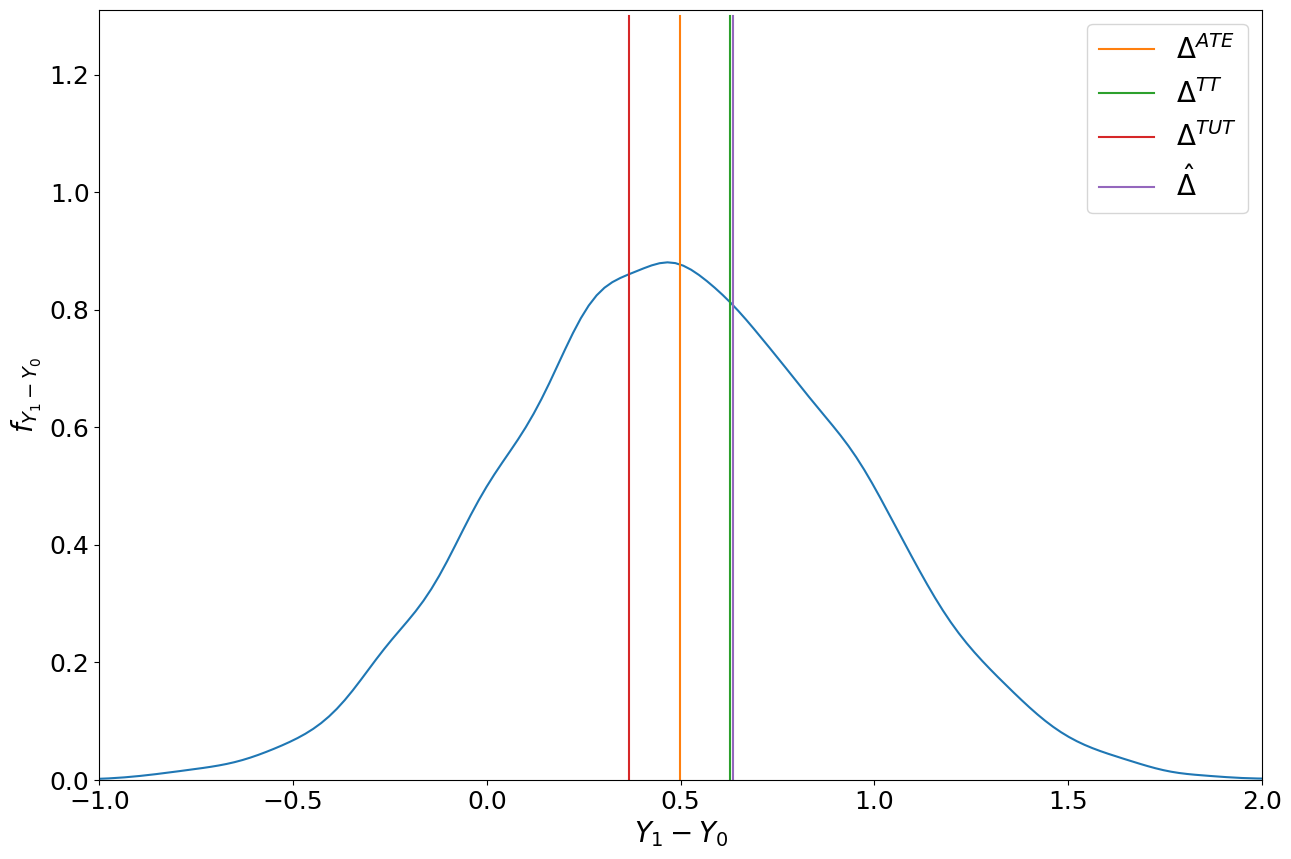

In [10]:
# set up figure object
ax = plt.figure(figsize=(15, 10))
plt.ylabel("$f_{Y_1 - Y_0}$", fontsize=20)
plt.xlabel("$Y_1 - Y_0$", fontsize=20)
plt.axis([-1, 2, 0.0, 1.31])

# plot distribution of individual effects
sns.distplot(Delta, kde=True, hist=False)

# plot average effect parameters
plt.plot([ATE, ATE], [0.00, 1.3], label=r"$\Delta^{ATE}$")
plt.plot([TT, TT], [0.00, 1.3], label=r"$\Delta^{TT}$")
plt.plot([TUT, TUT], [0.00, 1.3], label=r"$\Delta^{TUT}$")
plt.plot([effect_estimate, effect_estimate], [0.00, 1.3], label=r"$\hat{\Delta}$")


plt.legend(prop={"size": 20})

Text(0.5, 0.98, 'Abscence of essential heterogeneity')

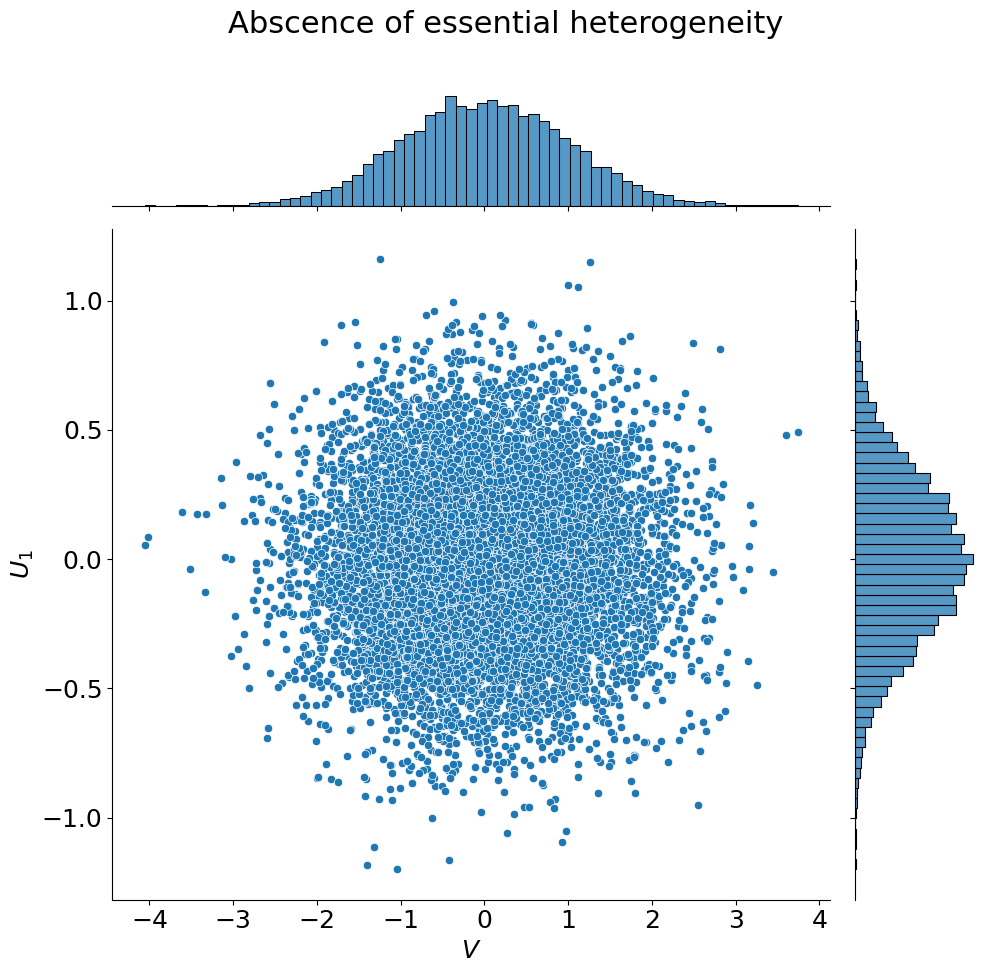

In [11]:
g1 = sns.jointplot(x=df["V"], y=df["U1"], height=10).set_axis_labels("$V$", "$U_1$", fontsize=18)
g1.fig.subplots_adjust(top=0.9)
g1.fig.suptitle("Abscence of essential heterogeneity", fontsize=22)

Text(0.5, 0.98, 'Presence of essential heterogeneity')

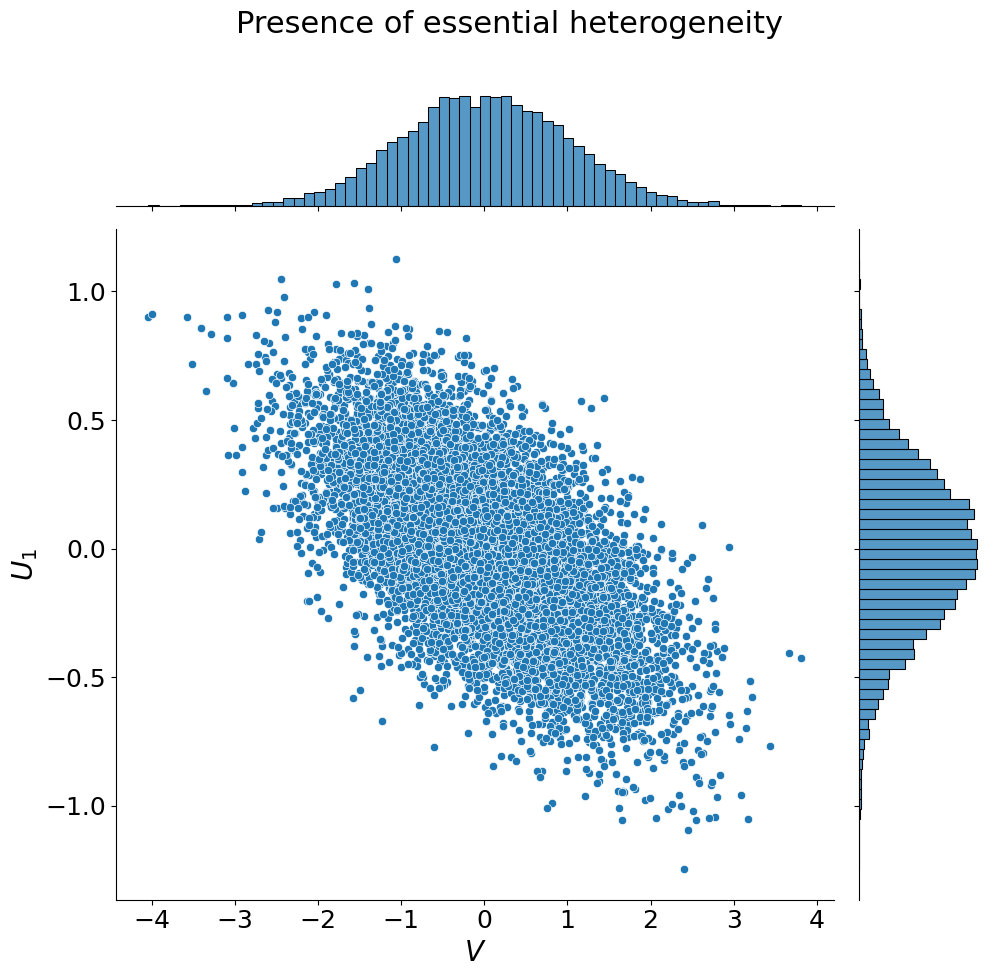

In [12]:
g2 = sns.jointplot(x=df_eh["V"], y=df_eh["U1"], height=10).set_axis_labels("$V$", "$U_1$", fontsize=20)
g2.fig.subplots_adjust(top=0.9)
g2.fig.suptitle("Presence of essential heterogeneity", fontsize=22)

## The Marginal Treatment Effect

- The concept was first introduced by Björklund & Moffitt (1987) and advanced by a broad variety of papers by Heckman & Vytlacil (1999, 2001, 2005, 2007)

- It is defined as the effect of treatment for individuals who are indifferent between taking the treatment and not. In terms of the Roy model framework it is characterized by the following equation

$$
\begin{align*}
\Delta^{MTE}(x,u_D) = E[Y_1 -Y_0|X=x, U_D=u_D]\\
\\
\end{align*}
$$

- It can be interpreted as the *willingness to pay* for treatment participation of individuals with characteristics $Z_i=z$ at the margin


- **Note:** Instead of explicitly assigning one value to a given policy intervention, $\Delta^{MTE}$ provides a continuum of effects along the distribution of the unobservable variable $V$


- $V_i$ enters the choice function $D_i$ with a negative sign $\Rightarrow$ Individuals with $U_D$ close to zero are most likely to select themselves into treatment.
 

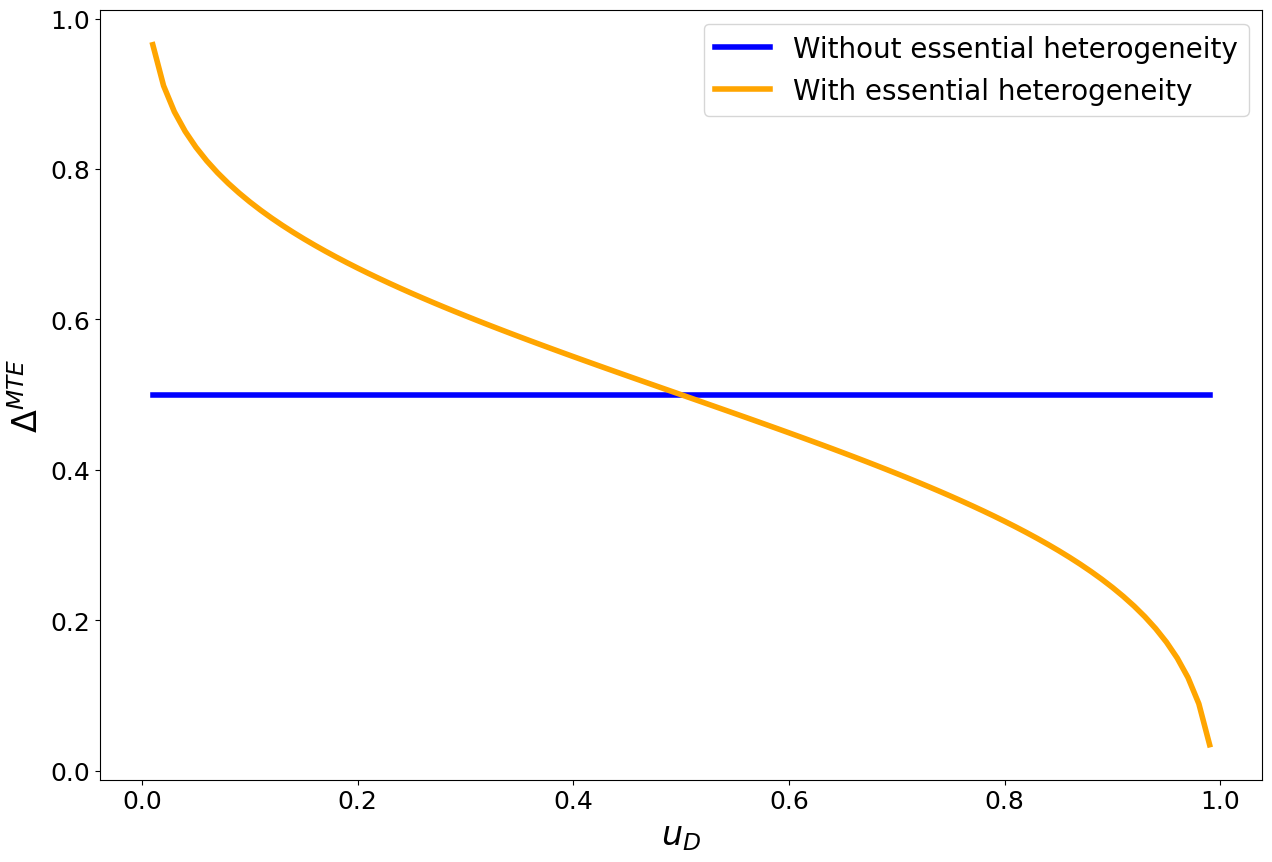

In [13]:
# Plot MTE curves using simulation parameters
ax = plt.figure(figsize=(15, 10))

plt.ylabel(r"$\Delta^{MTE}$", fontsize=24)
plt.xlabel("$u_D$", fontsize=24)

labels = ["Without essential heterogeneity", "With essential heterogeneity"]
colors = ["blue", "orange"]
configs = [config_no_eh, config_eh]
datasets = [df, df_eh]

quantiles = np.arange(0.01, 1.0, 0.01)

for counter, config in enumerate(configs):
    # Get parameters from config
    sim = config.simulation
    beta1 = np.array(sim.coefficients_treated)
    beta0 = np.array(sim.coefficients_untreated)
    cov = np.array(sim.covariance)
    cov1V = cov[0, 2]  # Covariance between U1 and V
    cov0V = cov[1, 2]  # Covariance between U0 and V

    # For MTE calculation, we need X values - use mean of data
    # MTE(u_D) = E[beta1 - beta0] * X + (cov1V - cov0V) * Phi^{-1}(u_D)
    # With intercept model: MTE(u_D) = (beta1[0] - beta0[0]) + (cov1V - cov0V) * Phi^{-1}(u_D)
    mte_base = beta1[0] - beta0[0]
    mte = mte_base + (cov1V - cov0V) * norm.ppf(quantiles)

    plt.plot(quantiles, mte, label=labels[counter], color=colors[counter], linewidth=4)

plt.legend(prop={"size": 20})

- $\Delta^{MTE}$ is constant in the absence of essential heterogeneity whereas decreasing respectively increasing values indicate the presence of essential heterogeneity. Why?

- Additionally whether $\Delta^{MTE}$ is increasing or decreasing along $u_D$ provides information about which kind of selection on gains take place

- In addition it is also possible to derive all conventional effects from $\Delta^{MTE}$ by applying effect specific weights along the distribution of $V$:


$$
\begin{align*}
\omega^{ATE}(x,u_D) &= 1.0\\
\omega^{TT}(x,u_D) &= \frac{\int_{u_D}^{1}f(p|X=x)dp}{E[P|X=x]}\\
\omega^{TUT}(x,u_D) &= \frac{\int_{0}^{u_D}f(p|X=x)dp}{E[1-P|X=x]}\\
\end{align*}
$$

Formally:

$$
\begin{align*}
\Delta^j = \int_0^1 \omega_j(x,u_D) \Delta^{MTE}(x,u_D)du_D\\
\text{ for } j = \text{ ATE, TT, TUT}
\end{align*}
$$

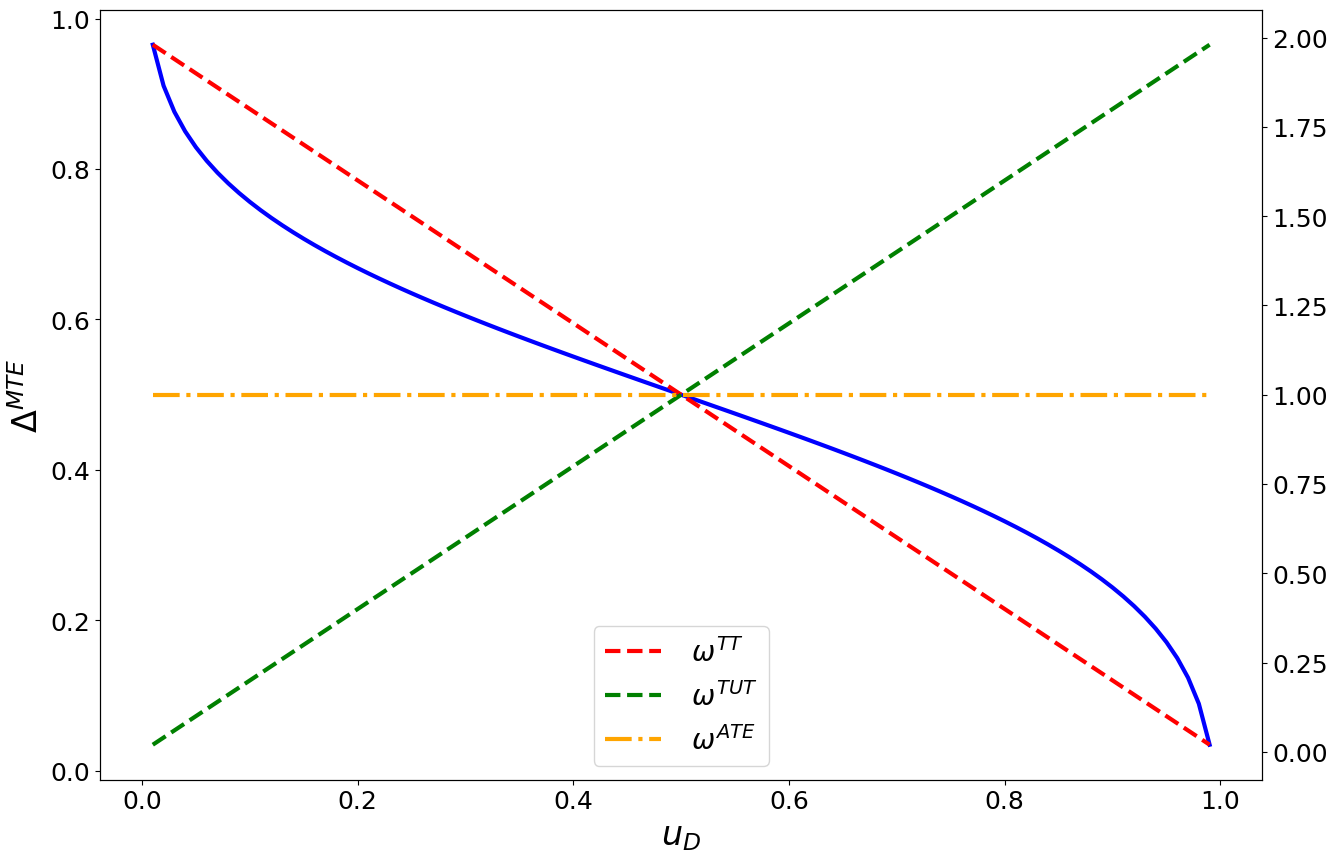

In [14]:
# Calculate MTE weights for essential heterogeneity case
sim_eh = config_eh.simulation
gamma = np.array(sim_eh.coefficients_choice)

# Compute propensity scores
# Need to construct Z from data - use X variables plus instrument
# For simplicity, compute propensity from the choice equation
# P(D=1|Z) = Phi(gamma * Z)
# Here we'll use the simulated V to back out propensity

# Get parameters for MTE
beta1 = np.array(sim_eh.coefficients_treated)
beta0 = np.array(sim_eh.coefficients_untreated)
cov = np.array(sim_eh.covariance)
cov1V = cov[0, 2]
cov0V = cov[1, 2]

mte_base = beta1[0] - beta0[0]
mte = mte_base + (cov1V - cov0V) * norm.ppf(quantiles)

# Use propensity scores from the data
# P(D=1) can be approximated from the treatment indicator
propensity_mean = df_eh["D"].mean()

# For the weights, we need the distribution of propensity scores
# Since we simulated, we can use: P(D=1|Z) = Phi(gamma'Z) where D = 1{gamma'Z > V}
# The propensity score is Phi(gamma'Z)
# From simulated data, we can estimate this

# Compute integral approximations for weights
integral_TT = np.array(
    [np.mean(df_eh["D"] * (norm.cdf(df_eh["V"]) > quantiles[i])) / propensity_mean for i in range(len(quantiles))]
)
integral_TUT = np.array(
    [
        np.mean((1 - df_eh["D"]) * (norm.cdf(df_eh["V"]) <= quantiles[i])) / (1 - propensity_mean)
        for i in range(len(quantiles))
    ]
)

# Simpler weight calculation based on theory
omega_TT = np.array([(1 - quantiles[i]) for i in range(len(quantiles))]) / (1 - propensity_mean) * 2
omega_TUT = np.array([quantiles[i] for i in range(len(quantiles))]) / propensity_mean * 2
omega_ATE = np.ones(len(quantiles))

# Normalize weights
omega_TT = omega_TT / np.mean(omega_TT)
omega_TUT = omega_TUT / np.mean(omega_TUT)

# Plot
ax1 = plt.figure(figsize=(15, 10)).add_subplot(111)

plt.ylabel(r"$\Delta^{MTE}$", fontsize=24)
plt.xlabel("$u_D$", fontsize=24)
ax1.plot(quantiles, mte, color="blue", label=r" $\Delta^{MTE}$", linewidth=3.0)
ax2 = ax1.twinx()

ax2.plot(quantiles, omega_TT, color="red", linestyle="--", label=r" $\omega^{TT}$", linewidth=3.0)
ax2.plot(quantiles, omega_TUT, color="green", linestyle="--", label=r" $\omega^{TUT}$", linewidth=3.0)
ax2.plot(quantiles, omega_ATE, color="orange", linestyle="-.", label=r" $\omega^{ATE}$", linewidth=3.0)

plt.legend(prop={"size": 20})

In [15]:
string = (
    "      True Values  Weighted Values\n\n"
    "ATE:{0:>10.5f}{3:>15.5f}\nTT:{1:>11.5f}{4:>15.5f}\nTUT:{2:>10.5f}{5:>15.5f}"
)

# Apply weights to the mte
ATE_w = np.mean(np.multiply(np.array(mte), omega_ATE))
TT_w = np.mean(np.multiply(np.array(mte), omega_TT))
TUT_w = np.mean(np.multiply(np.array(mte), omega_TUT))
effects = [ATE, TT, TUT, ATE_w, TT_w, TUT_w]

# Print comparison to the true values
print(string.format(*effects))

print("\n\n\nNaive comparison: {:.5f}".format(effect_estimate))

      True Values  Weighted Values

ATE:   0.49733        0.50000
TT:    0.62764        0.60805
TUT:   0.36682        0.39195



Naive comparison: 0.63634


### Link to Local Average Treatment Effect

- The concept of the marginal treatment effect is closely related to the local average treatment effect ($\Delta^{LATE}$)


- More specifically, it can be shown that $\Delta^{LATE}$ converges to $\Delta^{MTE}$. It can be represented as follows:

$$
\begin{align*}
\Delta^{LATE}(u_D, u^{'}_D x) = E[Y_1 -Y_0| u_D > U_D > u^{'}_D, X=x]
\end{align*}
$$


- where $u_D$  and $u'_D$ are defined as the propensity scores for $Z=z$ and $Z= z'$ or equivalent as point in the unit interval of the distribution of $V$


- Taking the limit of $\Delta^{LATE}$ as $u_D$ approaches $u'_D$ reduced the equation above to the definition of  $\Delta^{MTE}$.


- Therefore  $\Delta^{LATE}$ can be defined more generally as a function dependent of $\Delta^{MTE}$:


$$
\begin{align*}
\Delta^{LATE} = \frac{1}{u_D - u'_D} \int_0^1\Delta^{MTE}(x,u_D) du_D
\end{align*}
$$

## Estimation via grmpy

In [ ]:
# Estimate MTE using grmpy's parametric estimator
# Load estimation config that includes both simulation and estimation settings
est_config = grmpy.process_config("files/eh_estimation.grmpy.yml")

# Run estimation on the simulated data with essential heterogeneity
rslt = grmpy.estimate(est_config, df_eh)

In [17]:
# Display config file content
with open("files/eh.grmpy.yml") as f:
    print(f.read())

# Configuration with essential heterogeneity
# Non-zero covariance between U1 and V
SIMULATION:
  FUNCTION: roy_model
  PARAMS:
    agents: 10000
    seed: 2356
    coefficients_treated: [0.5, 1.0]
    coefficients_untreated: [0.0, 1.0]
    coefficients_choice: [0.0, 0.5, 0.5]
    covariance:
      - [0.10, 0.00, -0.20]
      - [0.00, 0.10, 0.00]
      - [-0.20, 0.00, 1.00]



In [ ]:
# Display estimation results
print("Estimated coefficients:")
print("\nTreated outcome equation (Y1 = beta1 * X + U1):")
for i, val in enumerate(rslt.coefficients["b1"]):
    print(f"  beta1[{i}]: {val:.4f}")

print("\nUntreated outcome equation (Y0 = beta0 * X + U0):")
for i, val in enumerate(rslt.coefficients["b0"]):
    print(f"  beta0[{i}]: {val:.4f}")

print("\nEstimation metadata:")
for key, val in rslt.metadata.items():
    print(f"  {key}: {val}")

## Comparing estimation strategies

- We will now compare different estimation strategies regarding their capability to evaluate the average effect of treatment in the presence of essential heterogeneity. 


- In particular we will compare results obtained by:  
    - **Naive comparison**  
    - **Ordinary Least Squares** 
    - **Instrumental Variables**  
        - **Conventional IV**  
        - **Local IV**  
        
        
- For this purpose we will conduct a monte carlo simulation approach:
    - We simulate a dataset of 10000 individuals 
    - Compute $\mu_1(X_i)$, $\mu_0(X_i)$, $\mu_D(Z_i)$  for all individuals
    - Each iteration of the monte calo simulation consists of three steps:
        * We draw unobservable variables from a mutlivariate normal distribution with mean zero and covariance matrix $\Sigma$, which has the following form
$$
\begin{align*}
\\
\Sigma =  \begin{bmatrix}
    0.01 & 0 & \frac{\rho_{1,V}}{0.1}  \\
    0 & 0.01 & 0 \\
    \frac{\rho_{1,V}}{0.1}  & 0 & 1 \\
  \end{bmatrix}
\\
\\
\end{align*}
$$
        * Next we combine the simulated unobservable variables with $\mu_1(X_i)$, $\mu_0(X_i)$ and $\mu_D(Z_i)$          
        * During each step we conduct four estimations for the ATE
        
        
- We will iterate over this process 10 times whereupon  the correlation between $U_1$ and $V$, captured by $\rho_{1,V}$ increases during each iteration 

In [ ]:
# Monte Carlo simulation comparing estimation strategies
# This demonstrates how different estimators perform under varying levels of essential heterogeneity

from auxiliary import monte_carlo, plot_monte_carlo_results

# Run Monte Carlo with fewer iterations for demonstration
# (increase num_iterations for more precise results)
mc_results = monte_carlo("files/mc.grmpy.yml", num_iterations=50, rho_grid=np.linspace(0, 0.8, 9))

# Plot the results
fig = plot_monte_carlo_results(mc_results)
plt.tight_layout()

# Replication Excerise 

Next we will focus on reproducing the results for the marginal treatment effect by Carneiro et al. (2011). Due to reasons of privacy regarding local variables, we are not able to merge the data provided by the authors so that they fully coincide with the original data set. Therefore our replication setup makes use of a mock data set. For this purpose we randomly merge the individual specific data with the local characteristics.

In [ ]:
# Replication exercise using simulated data
# Since the original Carneiro et al. (2011) data requires special access,
# we demonstrate the estimation approach using simulated data that mimics
# the education/wage structure from the paper.

# Create a simulated dataset with education as treatment and wages as outcome
# The covariance structure is chosen to reflect realistic patterns of selection
# into higher education based on expected returns.

replication_config = grmpy.process_config("files/eh_estimation.grmpy.yml")
sim_result = grmpy.simulate(replication_config)
df_replication = sim_result.data

print(f"Simulated dataset: {len(df_replication)} observations")
print(f"Treatment rate: {df_replication['D'].mean():.2%}")
print(f"\nSample of the data:")
df_replication.head()

In the next step we have to create a inititalization file that fully coincides with the setup by Carneiro et. al. (2011). Therefore we use the information that the authors provide in their appendix to create the following init file:

In [ ]:
# Display the estimation configuration
# This shows the specification that would be used for actual data
print("Estimation Configuration:")
print("=" * 50)
print(f"Estimation function: {replication_config.estimation.function}")
print(f"Dependent variable: {replication_config.estimation.dependent}")
print(f"Treatment indicator: {replication_config.estimation.treatment}")
print(f"Treated covariates: {replication_config.estimation.covariates_treated}")
print(f"Untreated covariates: {replication_config.estimation.covariates_untreated}")
print(f"Choice covariates: {replication_config.estimation.covariates_choice}")
print(f"Optimizer: {replication_config.estimation.optimizer}")

In [ ]:
# Fit the parametric model using maximum likelihood estimation
rslt_replication = grmpy.estimate(replication_config, df_replication)

print("Parametric estimation completed.")
print(f"Number of MTE points: {len(rslt_replication.mte)}")

In [ ]:
# Plot estimated MTE from parametric estimation
from auxiliary import plot_est_mte

fig, ax = plt.subplots(figsize=(12, 8))
mte_est, quantiles_est = plot_est_mte(rslt_replication, config_path="files/eh_estimation.grmpy.yml", ax=ax)
plt.title("Parametric MTE Estimation", fontsize=18)
plt.tight_layout()

In [ ]:
# Compare parametric vs true MTE
# In the replication setting, we would compare to nonparametric estimates
# Here we compare to the true values from our simulation

# Get true parameters from simulation config
sim = replication_config.simulation
beta1 = np.array(sim.coefficients_treated)
beta0 = np.array(sim.coefficients_untreated)
cov = np.array(sim.covariance)

print("True vs Estimated Parameters")
print("=" * 50)
print(f"\nIntercept difference (beta1[0] - beta0[0]):")
print(f"  True: {beta1[0] - beta0[0]:.4f}")
print(f"  Estimated: {rslt_replication.coefficients['b1'][0] - rslt_replication.coefficients['b0'][0]:.4f}")

print(f"\nSlope coefficients:")
print(f"  True beta1[1]: {beta1[1]:.4f}, Estimated: {rslt_replication.coefficients['b1'][1]:.4f}")
print(f"  True beta0[1]: {beta0[1]:.4f}, Estimated: {rslt_replication.coefficients['b0'][1]:.4f}")

In [ ]:
# Final comparison: Compute treatment effect estimates
from auxiliary import compare_estimators

# Compare different estimators
comparison = compare_estimators(df_replication)
print("Comparison of Treatment Effect Estimators")
print("=" * 50)
print(comparison.to_string(index=False))

# Note: The key insight from Carneiro et al. (2011) is that
# simple IV estimates may not capture the full heterogeneity
# in treatment effects, which is why the MTE framework is valuable.